# ReAct Agent from Scratch - using ConverseAPI without ToolCalling Feature

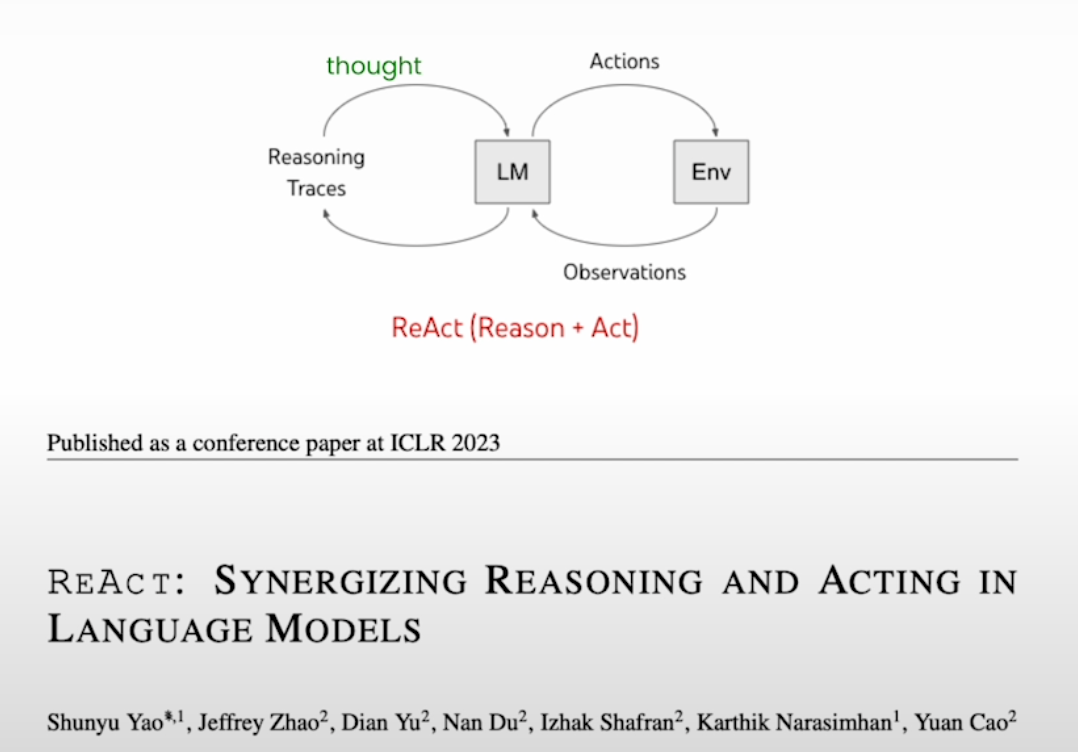

This notebook introduces how to build a simple reactive agent using AWS Bedrock Converse SDK. The agent will interact with a conversational model to process and respond to messages.
[Reference: https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/2/build-an-agent-from-scratch]

In [1]:
import boto3, json
import re
from enum import Enum

# Create a session with AWS and initialize a Bedrock client for conversational AI models
session = boto3.Session()
bedrock = session.client(service_name='bedrock-runtime')


In [2]:

class Models(Enum):
    # Enum for storing model identifiers for different AI models.
    # Each member represents a specific model hosted by various platforms like Anthropic and Meta.
    
    Sonnet = "anthropic.claude-3-sonnet-20240229-v1:0"  
    Haiku = "anthropic.claude-3-haiku-20240307-v1:0"   
    Llama = "meta.llama3-8b-instruct-v1:0"            
    Cohere = "cohere.command-r-plus-v1:0"      

In [3]:
# List to hold the conversation's flow
message_list = []

# Starting message from the user to the model
initial_message = {
    "role": "user",
    "content": [
        { "text": "How are you today?" } 
    ],
}

# Append the initial message to the conversation list
message_list.append(initial_message)


In [4]:
# Using Bedrock SDK to send a message to the model and get a response
response = bedrock.converse(
    modelId=Models.Sonnet.value,
    messages=message_list,  # Conversation history
    inferenceConfig={
        "maxTokens": 3000,  # Maximum length of the model's response
        "temperature": 0    # Sampling temperature, 0 for deterministic response
    },
)


In [5]:
# Extract the message part of the response from the model
response_message = response['output']['message']

# Print the response message formatted as JSON for readability
print(json.dumps(response_message, indent=4))


{
    "role": "assistant",
    "content": [
        {
            "text": "I'm doing well, thanks for asking! I'm an AI assistant created by Anthropic to be helpful, harmless, and honest."
        }
    ]
}


In [6]:
# Descriptive text about how the agent should behave and process inputs and outputs in a loop

prompt = """You are a chatbot who responds based on Reasoning and Action (ReAct) pattern adopted to show case tool/funtion calling.
Below are the instructions that are provided to you to successfully respond to user queries. 
Ensure you carefully read the instruction to adhere to ReAct based thinking, reasoning and acting. 

INSTRUCTIONS
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE and stop generating output.
Ensure you run only one action at a time.
You will NOT generate the Oberservation. You will wait for Observation to be sent you. The observation will be the result of running those actions.

Available actions are listed below to chose from:
calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed


Example session: Below examples in example_session_1* shows the sequence of conversation to get to the desired output. 

<example_session_1a>
Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog

PAUSE
</example_session_1a>

You will be called again with below observation:

<example_session_1b>
Observation: A Bulldog weights 51 lbs
</example_session_1b>

You then output results based on the Observation:

<example_session_1c>
Answer: A bulldog weights 51 lbs
</example_session_1c>
""".strip()

In [7]:
class Agent:
    # Initialize the Agent instance with a specific model.
    def __init__(self, model: Models):
        # Set the system prompt used throughout the conversation.
        self.system = prompt  
        # Initialize an empty list to store conversation messages.
        self.messages = []
        # Store the model ID for use in conversation.
        self.useModelID = model.value
        # Logging the initialization process.
        print("Model used: " + model.value)
        print("Messages cleared")
        print("=====INITIALIZED========")

    # This method is called when an instance of Agent is called like a function.
    def __call__(self, message):
        # Append user's message to the messages list.
        self.messages.append({"role": "user", "content": [{"text": message}]})
        # Process the conversation using the execute method.
        result = self.execute()
        # Append the system's (assistant's) response to the messages list.
        self.messages.append({"role": "assistant", "content": [{"text": result}]})
        # Return the assistant's response.
        return result

    # Method to execute the conversation logic using the Bedrock API.
    def execute(self):
        # Make a call to the Bedrock API with the specified model ID and configuration.
        response = bedrock.converse(
            modelId=self.useModelID,
            system=[{"text": self.system}],
            messages=self.messages,
            inferenceConfig={
                "maxTokens": 2000,  # Maximum number of tokens that the model can generate.
                "temperature": 0.0  # Temperature controls the randomness of the response; 0.0 makes it deterministic.
            },
        )
        # Return the text part of the message from the response.
        return response['output']['message']['content'][0]['text']
    

In [8]:
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        print(">>"+name)
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [9]:
abot = Agent(Models.Sonnet)

Model used: anthropic.claude-3-sonnet-20240229-v1:0
Messages cleared
=====INITIALIZED========


In [10]:
result = abot("How much does a toy poodle weigh?")
print(result)

Thought: To find out the average weight of a toy poodle, I should use the average_dog_weight action and pass in "Toy Poodle" as the breed.

Action: average_dog_weight: Toy Poodle

PAUSE


In [11]:
result = average_dog_weight("Toy Poodle")
print(result)

a toy poodles average weight is 7 lbs


In [12]:
next_prompt = "Observation: {}".format(result)
print(next_prompt)

Observation: a toy poodles average weight is 7 lbs


In [13]:
abot(next_prompt)

"Answer: A toy poodle's average weight is 7 lbs."

In [14]:
print(json.dumps(abot.messages, indent=4))

[
    {
        "role": "user",
        "content": [
            {
                "text": "How much does a toy poodle weigh?"
            }
        ]
    },
    {
        "role": "assistant",
        "content": [
            {
                "text": "Thought: To find out the average weight of a toy poodle, I should use the average_dog_weight action and pass in \"Toy Poodle\" as the breed.\n\nAction: average_dog_weight: Toy Poodle\n\nPAUSE"
            }
        ]
    },
    {
        "role": "user",
        "content": [
            {
                "text": "Observation: a toy poodles average weight is 7 lbs"
            }
        ]
    },
    {
        "role": "assistant",
        "content": [
            {
                "text": "Answer: A toy poodle's average weight is 7 lbs."
            }
        ]
    }
]


In [15]:
abot = Agent(Models.Sonnet)

Model used: anthropic.claude-3-sonnet-20240229-v1:0
Messages cleared
=====INITIALIZED========


In [16]:
question = """I have 2 dogs, a border collie and a scottish terrier. What is their combined weight?"""
print(abot(question))

Thought: To find the combined weight of the two dogs, I need to look up the average weight for each breed and then add them together.

Action: average_dog_weight: Border Collie

PAUSE


In [17]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [18]:
print(abot(next_prompt))

Thought: Okay, I now have the average weight for a Border Collie, which is 37 lbs. Next I need to get the average weight for a Scottish Terrier and add it to 37 lbs.

Action: average_dog_weight: Scottish Terrier  

PAUSE


In [19]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [20]:
print(abot(next_prompt))

Thought: I now have the average weights for both breeds - Border Collie at 37 lbs and Scottish Terrier at 20 lbs. To get the combined weight, I just need to add them together.

Action: calculate: 37 + 20

PAUSE


In [21]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

Observation: 57


In [22]:
print(abot(next_prompt))

Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.


### Add loop to automate actions

In [23]:
# Regular expression to detect action commands in agent's responses

action_re = re.compile(r'^Action: (\w+): (.*)$')  # Python regular expression to detect action

In [24]:
# Function to process queries up to a maximum number of turns

def query(question, model: Models, max_turns=5):
    i = 0
    bot = Agent(model)
    next_prompt = question
    print(f"*Starting the query loop with the question: \n{question}\n")
    
    while i < max_turns:
        i += 1
        print(f">>Turn {i}: Current prompt to agent: \n{next_prompt}\n")
        
        result = bot(next_prompt)
        print(f"Agent's response: \n--------\n{result}\n-----\n")
        
        actions = [
            action_re.match(a) 
            for a in result.split('\n') 
            if action_re.match(a)
        ]
        
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception(f"*Unknown action: {action}: {action_input}")
            
            print(f"*Action detected: \n{action} with input {action_input}")
            print(f" -- *Executing action: {action} with input {action_input}\n")
            
            observation = known_actions[action](action_input)
            print(f"*Observation result from action: {observation}\n")
            
            next_prompt = f"Observation: {observation}"
            print(f"*Next prompt based on observation: {next_prompt}\n")
        else:
            print("*No actions detected in the response. Ending loop.")
            return

    print("*Maximum number of turns reached. Ending query.")


In [25]:
question = """I have 2 dogs, a Border Collie and a Scottish Terrier. What is their combined weight?"""

In [26]:
query(question, Models.Sonnet)

Model used: anthropic.claude-3-sonnet-20240229-v1:0
Messages cleared
=====INITIALIZED========
*Starting the query loop with the question: 
I have 2 dogs, a Border Collie and a Scottish Terrier. What is their combined weight?

>>Turn 1: Current prompt to agent: 
I have 2 dogs, a Border Collie and a Scottish Terrier. What is their combined weight?

Agent's response: 
--------
Thought: To find the combined weight of the two dogs, I need to look up the average weight for each breed and then add them together.
Action: average_dog_weight: Border Collie

PAUSE
-----

*Action detected: 
average_dog_weight with input Border Collie
 -- *Executing action: average_dog_weight with input Border Collie

*Observation result from action: a Border Collies average weight is 37 lbs

*Next prompt based on observation: Observation: a Border Collies average weight is 37 lbs

>>Turn 2: Current prompt to agent: 
Observation: a Border Collies average weight is 37 lbs

Agent's response: 
--------
Thought: Okay, 

In [27]:
query(question, Models.Llama)


Model used: meta.llama3-8b-instruct-v1:0
Messages cleared
=====INITIALIZED========
*Starting the query loop with the question: 
I have 2 dogs, a Border Collie and a Scottish Terrier. What is their combined weight?

>>Turn 1: Current prompt to agent: 
I have 2 dogs, a Border Collie and a Scottish Terrier. What is their combined weight?

Agent's response: 
--------


Thought: I need to find the average weight of each breed and then add them together.

Action: average_dog_weight: Border Collie
PAUSE
-----

*Action detected: 
average_dog_weight with input Border Collie
 -- *Executing action: average_dog_weight with input Border Collie

*Observation result from action: a Border Collies average weight is 37 lbs

*Next prompt based on observation: Observation: a Border Collies average weight is 37 lbs

>>Turn 2: Current prompt to agent: 
Observation: a Border Collies average weight is 37 lbs

Agent's response: 
--------


Thought: Now I need to find the average weight of the Scottish Terrier 

In [28]:
query(question, Models.Cohere)


Model used: cohere.command-r-plus-v1:0
Messages cleared
=====INITIALIZED========
*Starting the query loop with the question: 
I have 2 dogs, a Border Collie and a Scottish Terrier. What is their combined weight?

>>Turn 1: Current prompt to agent: 
I have 2 dogs, a Border Collie and a Scottish Terrier. What is their combined weight?

Agent's response: 
--------
Thought: To answer this question, I need to find the average weight of a Border Collie and a Scottish Terrier, and then add those weights together.

Action: average_dog_weight: Border Collie
average_dog_weight: Scottish Terrier
-----

*Action detected: 
average_dog_weight with input Border Collie
 -- *Executing action: average_dog_weight with input Border Collie

*Observation result from action: a Border Collies average weight is 37 lbs

*Next prompt based on observation: Observation: a Border Collies average weight is 37 lbs

>>Turn 2: Current prompt to agent: 
Observation: a Border Collies average weight is 37 lbs

Agent's res